(regression)=
# Regression

## Introduction

In this chapter, you'll learn how to run linear regressions with code.

If you're running this code (either by copying and pasting it, or by downloading it using the icons at the top of the page), you may need to the packages it uses by, for example, running `pip install packagename` on your computer's command line. (If you're not sure what a command line is, take a quick look at the basics of coding chapter.)

Most of this chapter will rely on [statsmodels](https://www.statsmodels.org/stable/index.html) with some use of [**linearmodels**](https://bashtage.github.io/linearmodels/). Some of the material in this chapter follows [Grant McDermott](https://grantmcdermott.com/)'s excellent notes and the [Library of Statistical Translation](https://lost-stats.github.io/).

### Notation and basic definitions

Greek letters, like $\beta$, are the truth and represent parameters. Modified Greek letters are an estimate of the truth, for example $\hat{\beta}$. Sometimes Greek letters will stand in for vectors of parameters. Most of the time, upper case Latin characters such as $X$ will represent random variables (which could have more than one dimension). Lower case letters from the Latin alphabet denote realised data, for instance $x$ (which again could be multi-dimensional).  Modified Latin alphabet letters denote computations performed on data, for instance $\bar{x} = \frac{1}{n} \displaystyle\sum_{i} x_i$ where $n$ is number of samples.

Ordinary least squares (OLS) regression can be used to *estimate* the parameters of certain types of model, most typically models of the form

$$
y = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2
$$

This generic model says that the value of an outcome variable $y$ is a linear function of one or more input predictor variables $x_i$, where the $x_i$ could be transforms of original data. But the above equation is a platonic ideal, what we call a data generating process (DGP). OLS allows us to recover *estimates* of the parameters of the model , i.e. to find $\hat{\beta_i}$ and to enable us to write an estimated model:

$$
y = \hat{\beta_0} + \hat{\beta_1} \cdot x_1 + \hat{\beta_2} \cdot x_2 + \epsilon
$$

This equation can also be expressed in matrix form as

$$
y = x'\cdot \hat{\beta} + \epsilon
$$

where $x' = (1, x_1, \dots, x_{n})'$ and $\hat{\beta} = (\hat{\beta_0}, \hat{\beta_1}, \dots, \hat{\beta_{n}})$.

Given data $y_i$ stacked to make a vector $y$ and $x_{i}$ stacked to make a matrix $X$, this can be solved for the coefficients $\hat{\beta}$ according to

$$
\hat{\beta} = \left(X'X\right)^{-1} X'y
$$

To be sure that the estimates of these parameters are the *best linear unbiased estimate*, a few conditions need to hold: the Gauss-Markov conditions:

1. $y$ is a linear function of the $\beta_i$
2. $y$ and the $x_i$ are randomly sampled from the population.
3. There is no perfect multi-collinearity of variables.
4. $\mathbb{E}(\epsilon | x_1, \dots, x_n) = 0$ (unconfoundedness)
5. $\text{Var}(\epsilon | x_1, \dots, x_n) = \sigma^2$ (homoskedasticity)

(1)-(4) also guarantee that OLS estimates are unbiased and $\mathbb{E}(\hat{\beta}_i) = \beta_i$.

The classic linear model requires a 6th assumption; that $\epsilon \thicksim \mathcal{N}(0, \sigma^2)$.

The interpretation of regression coefficients depends on what their units are to begin with, but you can always work it out by differentiating both sides of the model equation with respect to the $x_i$. For example, for the first model equation above

$$
\frac{\partial y}{\partial x_i} = \beta_i
$$

so we get the interpretation that $\beta_i$ is the rate of change of y with respect to $x_i$. If $x_i$ and $y$ are in levels, this means that a unit increase in $x_i$ is associated with a $\beta_i$ units increase in $y$. If the right-hand side of the model is $\ln x_i$ then we get

$$
\frac{\partial y}{\partial x_i} = \beta_i \frac{1}{x_i} 
$$

with some abuse of notation, we can rewrite this as $\partial y = \beta_i \partial x_i/x_i$, which says that a percent change in $x_i$ is associated with a $\beta_i$ unit change in $y$. With a logged $y$ variable, it's a percent change in $x_i$ that is associated with a percent change in $y$, or $\partial y/y = \beta_i \partial x_i/x_i$ (note that both sides of this equation are unitless in this case). Finally, another example that is important in practice is that of log differences, eg $y = \beta_i (\ln x_i - \ln x_i')$. Again, we will abuse notation and say that this case may be represented as $\partial y = \beta_i (\partial x_i/x_i - \partial x_i'/x_i')$, i.e. the difference in two percentages, a *percentage point* change, in $x_i$ is associated with a $\beta_i$ unit change in $y$.

### Imports

Let's import some of the packages we'll be using:

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from pathlib import Path

In [2]:
# Set max rows displayed for readability
pd.set_option("display.max_rows", 6)
# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)

## Regression basics

There are two ways to run regressions in [**statsmodels**](https://www.statsmodels.org/stable/index.html); passing the data directly as objects, and using formulae. We'll see both but, just to get things started, let's use the formula API.

We'll use the starwars dataset to run a regression of mass on height for star wars characters. This example borrows very heavily from notes by [Grant McDermott](https://grantmcdermott.com/). First, let's bring the dataset in:

In [3]:
df = pd.read_csv(
    "https://github.com/aeturrell/coding-for-economists/raw/main/data/starwars.csv",
    index_col=0,
)
# Look at first few rows
df.head()

,name,height,mass,hair_color,eye_color,gender,homeworld,species
0,Luke Skywalker,172.0,77.0,blond,blue,male,Tatooine,Human
1,C-3PO,167.0,75.0,NaN,yellow,NaN,Tatooine,Droid
2,R2-D2,96.0,32.0,NaN,red,NaN,Naboo,Droid
3,Darth Vader,202.0,136.0,none,yellow,male,Tatooine,Human
4,Leia Organa,150.0,49.0,brown,brown,female,Alderaan,Human


Okay, now let's do a regression using OLS and a formula that says our y-variable is mass and our regressor is height:

In [4]:
results = smf.ols("mass ~ height", data=df).fit()

Well, where are the results!? They're stored in the object we created. To peek at them we need to call the summary function (and, for easy reading, I'll print it out too using `print`)

In [5]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   mass   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.040
Date:                Wed, 06 Oct 2021   Prob (F-statistic):              0.312
Time:                        17:38:03   Log-Likelihood:                -385.50
No. Observations:                  59   AIC:                             775.0
Df Residuals:                      57   BIC:                             779.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.8103    111.155     -0.124      0.9

What we're seeing here are really several tables glued together. To just grab the coefficients in a tidy format, use

In [6]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-13.8103,111.155,-0.124,0.902,-236.393,208.773
height,0.6386,0.626,1.020,0.312,-0.615,1.892


You'll have noticed that we got an intercept, even though we didn't specify one in the formula. **statsmodels** adds in an intercept by default because, most of the time, you will want one. To turn it off, add a `-1` at the end of the formula command, eg in this case you would call `smf.ols('mass ~ height -1', data=df).fit()`.

The fit we got in the case with the intercept was pretty terrible; a low $R^2$ and both of our confidence intervals are large and contain zero. What's going on? If there's one adage in regression that's always worth paying attention to, it's *always plot your data*. Let's see what's going on here:

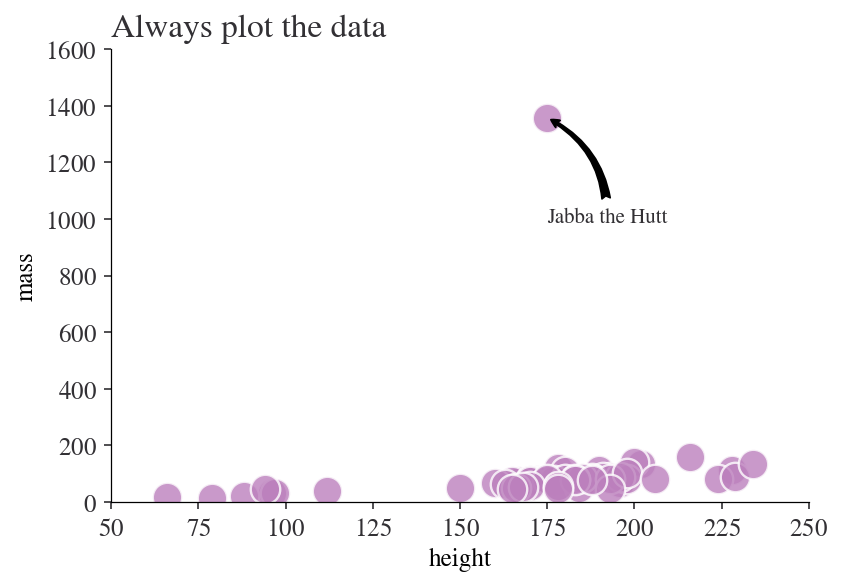

In [7]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="height", y="mass", s=200, ax=ax, legend=False, alpha=0.8)
ax.annotate(
    "Jabba the Hutt",
    df.iloc[df["mass"].idxmax()][["height", "mass"]],
    xytext=(0, -50),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="fancy",
        color="k",
        connectionstyle="arc3,rad=0.3",
    ),
)
ax.set_ylim(0, None)
ax.set_title("Always plot the data", loc="left")
plt.show()

Oh dear, Jabba's been on the paddy frogs again, and he's a bit of different case. When we're estimating statistical relationships, we have all kinds of choices and should be wary about arbitrary decisions of what to include or exclude in case we fool ourselves about the generality of the relationship we are capturing. Let's say we knew that we weren't interested in Hutts though, but only in other species: in that case, it's fair enough to filter out Jabba and run the regression without this obvious outlier. We'll exclude any entry that contains the string 'Jabba' in the `name` column:

In [8]:
results_outlier_free = smf.ols(
    "mass ~ height", data=df[~df["name"].str.contains("Jabba")]
).fit()
print(results_outlier_free.summary())

                            OLS Regression Results                            
Dep. Variable:                   mass   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     77.18
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           4.02e-12
Time:                        17:38:04   Log-Likelihood:                -252.48
No. Observations:                  58   AIC:                             509.0
Df Residuals:                      56   BIC:                             513.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.5408     12.561     -2.591      0.0

This looks a lot more healthy. Not only is the model explaining a *lot* more of the data, but the coefficients are now significant.

### Robust regression

Filtering out data is one way to deal with outliers, but it's not the only one; an alternative is to use a regression technique that is robust to such outliers. **statsmodels** has a variety of robust linear models that you can read more about [here](https://www.statsmodels.org/stable/examples/notebooks/generated/robust_models_0.html). To demonstrate the general idea, we will run the regression again but using a robust method.



In [9]:
results_robust = smf.rlm(
    "mass ~ height", data=df, M=sm.robust.norms.TrimmedMean(0.5)
).fit()
print(results_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                   mass   No. Observations:                   59
Model:                            RLM   Df Residuals:                       57
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 06 Oct 2021                                         
Time:                        17:38:04                                         
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -31.4968      2.180    -14.451      0.0

There are many different 'M-estimators' available; in this case the TrimmedMean estimator gives a very similar result to the regression with the point excluded. We can visualise this, and, well, the results are not really very different in this case. Note that `abline_plot` just takes an intercept and coefficient from a fitted model and renders the line that they encode.

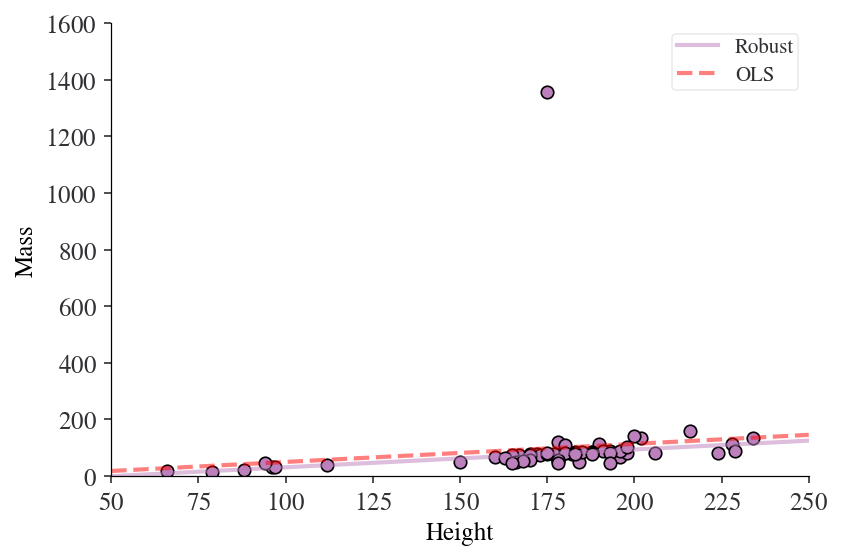

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["height"], df["mass"])
sm.graphics.abline_plot(model_results=results_robust, ax=ax, alpha=0.5, label="Robust")
sm.graphics.abline_plot(
    model_results=results, ax=ax, color="red", label="OLS", alpha=0.5, ls="--"
)
ax.legend()
ax.set_xlabel("Height")
ax.set_ylabel("Mass")
ax.set_ylim(0, None)
plt.show()

### Standard errors

You'll have seen that there's a column for the standard error of the estimates in the regression table and a message saying that the covariance type of these is 'nonrobust'. Let's say that, instead, we want to use Eicker-Huber-White robust standard errors, aka "HC2" standard errors. We can specify to use these up front standard errors up front in the fit method:

In [11]:
(smf.ols("mass ~ height", data=df).fit(cov_type="HC2").summary().tables[1])

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-13.8103,23.456,-0.589,0.556,-59.782,32.162
height,0.6386,0.088,7.263,0.000,0.466,0.811


Or, alternatively, we can go back to our existing results and recompute the results from those:

In [12]:
print(results.get_robustcov_results("HC2").summary())

                            OLS Regression Results                            
Dep. Variable:                   mass   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     52.75
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           1.16e-09
Time:                        17:38:04   Log-Likelihood:                -385.50
No. Observations:                  59   AIC:                             775.0
Df Residuals:                      57   BIC:                             779.2
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.8103     23.456     -0.589      0.5

There are several different types of standard errors available in **statsmodels**:

- ‘HC0’, ‘HC1’, ‘HC2’, and ‘HC3’
- ‘HAC’, for heteroskedasticity and autocorrelation consistent standard errors, for which you may want to also use some keyword arguments
- 'hac-groupsum’, for Driscoll and Kraay heteroscedasticity and
autocorrelation robust standard errors in panel data, again for which you may have to specify extra keyword arguments
- 'hac-panel’, for heteroscedasticity and autocorrelation robust standard
errors in panel data, again with keyword arguments; and
- 'cluster' for clustered standard errors.

You can find information on all of these [here](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.get_robustcov_results.html?highlight=get_robustcov_results#statsmodels.regression.linear_model.OLSResults.get_robustcov_results). For more on standard errors in python, [this is a good](http://www.vincentgregoire.com/standard-errors-in-python/) link.

For now, let's look more closely at those last ones: clustered standard errors.



#### Clustered standard errors

Often, we know something about the structure of likely errors, namely that they occur in groups. In the below example we use one-way clusters to capture this effect in the errors.

Note that in the below example, we grab a subset of the data for which a set of variables we're interested in are defined, otherwise the below example would execute with an error because of missing cluster-group values.

In [13]:
xf = df.dropna(subset=["homeworld", "mass", "height", "species"])
results_clus = smf.ols("mass ~ height", data=xf).fit(
    cov_type="cluster", cov_kwds={"groups": xf["homeworld"]}
)
print(results_clus.summary())

                            OLS Regression Results                            
Dep. Variable:                   mass   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                     39.44
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           2.63e-07
Time:                        17:38:05   Log-Likelihood:                -361.23
No. Observations:                  55   AIC:                             726.5
Df Residuals:                      53   BIC:                             730.5
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.7955     29.150     -0.302      0.7

We can add two-way clustering of standard errors using the following:

In [14]:
xf = df.dropna(subset=["homeworld", "mass", "height", "species"])
two_way_clusters = np.array(xf[["homeworld", "species"]], dtype=str)
results_clus = smf.ols("mass ~ height", data=xf).fit(
    cov_type="cluster", cov_kwds={"groups": two_way_clusters}
)
print(results_clus.summary())

                            OLS Regression Results                            
Dep. Variable:                   mass   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                     35.10
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           1.96e-06
Time:                        17:38:05   Log-Likelihood:                -361.23
No. Observations:                  55   AIC:                             726.5
Df Residuals:                      53   BIC:                             730.5
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.7955     30.636     -0.287      0.7

As you would generally expect, the addition of clustering has increased the standard errors.

## Fixed effects and categorical variables

Fixed effects are a way of allowing the intercept of a regression model to vary freely across individuals or groups. It is, for example, used to control for any individual-specific attributes that do not vary across time in panel data.

Let's use the 'mtcars' dataset to demonstrate this. We'll read it in and set the datatypes of some of the columns at the same time.

In [15]:
mpg = pd.read_csv(
    "https://raw.githubusercontent.com/LOST-STATS/lost-stats.github.io/source/Data/mtcars.csv",
    dtype={"model": str, "mpg": float, "hp": float, "disp": float, "cyl": "category"},
)
mpg.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110.0,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110.0,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93.0,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110.0,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175.0,3.15,3.440,17.02,0,0,3,2


Now we have our data in we want to regress mpg (miles per gallon) on hp (horsepower) with fixed effects for cyl (cylinders). Now we *could* just pop in a formula like this `'mpg ~ hp + cyl'` because we took the trouble to declare that `cyl` was of datatype category when reading it in from the csv file. This means that statsmodels will treat it as a category and use it as a fixed effect by default.

But when I read that formula I get nervous that `cyl` might not have been processed correctly (ie it could have been read in as a float, which is what it looks like) and it might just be treated as a float (aka a continuous variable) in the regression. Which is not what we want at all. So, to be safe, and make our intentions explicit (even when the data is of type 'category'), it's best to use the syntax `C(cyl)` to ask for a fixed effect.

Here's a regression which does that:

In [16]:
results_fe = smf.ols("mpg ~ hp + C(cyl)", data=mpg).fit()
print(results_fe.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     28.59
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           1.14e-08
Time:                        17:38:06   Log-Likelihood:                -79.948
No. Observations:                  32   AIC:                             167.9
Df Residuals:                      28   BIC:                             173.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      28.6501      1.588     18.044      

We can see here that two of the three possible values of `cyl`:

In [17]:
mpg["cyl"].unique()

['6', '4', '8']
Categories (3, object): ['4', '6', '8']

have been added as fixed effects regressors. The way that `+C(cyl)` has been added makes it so that the coefficients given are relative to the coefficient for the intercept. We can turn the intercept off to get a coefficient per unique `cyl` value:

In [18]:
print(smf.ols("mpg ~ hp + C(cyl) -1", data=mpg).fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
C(cyl)[4]     28.6501      1.588     18.044      0.000      25.398      31.903
C(cyl)[6]     22.6825      2.228     10.180      0.000      18.119      27.246
C(cyl)[8]     20.1293      3.331      6.042      0.000      13.305      26.953
hp            -0.0240      0.015     -1.560      0.130      -0.056       0.008


When there is an intercept, the coefficients of fixed effect variables can be interpreted as being the average of $y$ for that class *compared* to the excluded classes holding all other categories and variables fixed. 

### High dimensional fixed effects, aka absorbing regression

Sometimes, you just have a LOT of fixed effects (and perhaps you don't particularly care about them individually). A common example is having a large number of firms as part of a panel. Fortunately, there are ways to make regression with high dimensional fixed effects be both fast and concise. (In Stata, this is provided by the `reghdfe` package.) Here, we will use the [**linearmodels**](https://bashtage.github.io/linearmodels/index.html) package, which is built on top of **statsmodels**.

Let's say we have a regression of the form

$$
y_i = x_i\cdot \beta + z_i\cdot \gamma +\epsilon_i
$$

where $y_i$ are observations indexed by $i$, $x_i$ are vectors of exogenous variables we care about the coefficients ($\beta$), $z_i$ are vectors of fixed effects we don't care too much about the coefficients (\gamma) for, and the $\epsilon_i$ are errors. Then we can use an *absorbing regression* to solve for the $\beta$ while ignoring the $\gamma$.

Here's an example using simulated data on workers taken from the **linearmodels** docs. Let's simulate some data first, with two fixed effects (state and firm) alongside the two exogenous variables we're interested in.

In [19]:
from numpy.random import default_rng

rng = default_rng()  # Random number generator

# Create synthetic input data
nobs = 1_000_000  # No. observations
state_id = rng.integers(50, size=nobs)  # State identifier
firm_id = rng.integers(nobs // 5, size=nobs)  # Firm identifier (mean of 5 workers/firm)
x = rng.standard_normal((nobs, 2))  # Exogenous variables
sim = pd.DataFrame(
    {
        "state_id": pd.Categorical(state_id),
        "firm_id": pd.Categorical(firm_id),
        "exog_0": x[:, 0],
        "exog_1": x[:, 1],
    }
)

# Create synthetic relationship
beta = [1, 3]  # coefficients of interest
state_effects = rng.standard_normal(state_id.max() + 1)
state_effects = state_effects[state_id]  # Generate state fixed effects
firm_effects = rng.standard_normal(firm_id.max() + 1)
firm_effects = firm_effects[firm_id]  # Generate firm fixed effects
eps = rng.standard_normal(nobs)  # Generate errors
# Generate endogeneous outcome variable
sim["y"] = (
    sim["exog_0"] * beta[0]
    + sim["exog_1"] * beta[1]
    + firm_effects
    + state_effects
    + eps
)
sim.head()

,state_id,firm_id,exog_0,exog_1,y
0,35,141460,1.578953,1.302026,1.827412
1,42,123853,-1.551595,-1.633460,-5.718165
2,4,157054,-0.086903,1.424592,9.137599
3,11,149312,-0.207918,0.656052,-0.298093
4,26,82686,0.404547,0.009800,2.342056


Now we pass this to **linearmodels** and with the `state_id` and `firm_id` variables entered via the `absorb` keyword argument:

In [21]:
from linearmodels.iv.absorbing import AbsorbingLS

mod = AbsorbingLS(
    sim["y"], sim[["exog_0", "exog_1"]], absorb=sim[["state_id", "firm_id"]]
)
print(mod.fit())

                         Absorbing LS Estimation Summary                          
Dep. Variable:                      y   R-squared:                          0.9385
Estimator:               Absorbing LS   Adj. R-squared:                     0.9233
No. Observations:             1000000   F-statistic:                     9.828e+06
Date:                Wed, Oct 06 2021   P-value (F-stat):                   0.0000
Time:                        17:40:06   Distribution:                      chi2(2)
Cov. Estimator:                robust   R-squared (No Effects):             0.9092
                                        Varaibles Absorbed:              1.987e+05
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog_0         0.9979     0.0010     989.87     0.0000      0.9959      0.9998
exog_1         3.000

So, from our 1,000,000 observations, we have roughly 200,000 fixed effects that have been scooped up and packed away, leaving us with just the coefficients, $\beta$, on the exogenous variables of interest.

## Transformations of regressors

This chapter is showcasing *linear* regression. What that means is that the model is linear in the regressors: but it doesn't mean that those regressors can't be some kind of (potentially non-linear) transform of the original features $x_i$.

### Logs and arcsinh

You have two options for adding in logs: do them before, or do them in the formula. Doing them before just makes use of standard dataframe operations to declare a new column:


In [22]:
mpg["lnhp"] = np.log(mpg["hp"])
print(smf.ols("mpg ~ lnhp", data=mpg).fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.6405      6.004     12.098      0.000      60.378      84.903
lnhp         -10.7642      1.224     -8.792      0.000     -13.265      -8.264


Alternatively, you can specify the log directly in the formula:

In [23]:
results_ln = smf.ols("mpg ~ np.log(hp)", data=mpg).fit()
print(results_ln.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.6405      6.004     12.098      0.000      60.378      84.903
np.log(hp)   -10.7642      1.224     -8.792      0.000     -13.265      -8.264


Clearly, the first method will work for `arcsinh(x)` and `log(x+1)`, but you can also pass both of these into the formula directly too. (For more on the pros and cons of arcsinh, see {cite}`bellemare2020elasticities`.) Here it is with arcsinh:

In [24]:
print(smf.ols("mpg ~ np.arcsinh(hp)", data=mpg).fit().summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         80.1041      6.850     11.694      0.000      66.115      94.094
np.arcsinh(hp)   -10.7646      1.224     -8.792      0.000     -13.265      -8.264


### Interaction terms and powers

This chapter is showcasing *linear* regression. What that means is that the model is linear in the regressors: but it doesn't mean that those regressors can't be some kind of non-linear transform of the original features $x_i$. Two of the most common transformations that you might want to use are *interaction terms* and *polynomial terms*. An example of an interaction term would be

$$
y = \beta_0 + \beta_1 x_1 \cdot x_2
$$

while an example of a polynomial term would be

$$
y = \beta_0 + \beta_1 x_1^2
$$

i.e. the last term enters only after it is multiplied by itself.

One note of warning: the interpretation of the effect of a variable is no longer as simple as was set out at the start of this chapter. To work out *what* the new interpretation is, the procedure is the same though: just take the derivative. In the case of the interaction model above, the effect of a unit change in $x_1$ on $y$ is now going to be a function of $x_2$. In the case of the polynomial model above, the effect of a unit change in $x_1$ on $y$ will be $2\beta_1 \cdot x_1$. For more on interaction terms, see {cite}`balli2013interaction`.

Alright, with all of that preamble out of the way, let's see how we actual do some of this! Let's try including a linear and squared term in the regression of `mpg` on `hp` making use of the numpy power function:

In [25]:
res_poly = smf.ols("mpg ~ hp + np.power(hp, 2)", data=mpg).fit()
print(res_poly.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4091      2.741     14.744      0.000      34.804      46.015
hp                 -0.2133      0.035     -6.115      0.000      -0.285      -0.142
np.power(hp, 2)     0.0004   9.84e-05      4.275      0.000       0.000       0.001


Now let's include the original term in hp, a term in disp, and the interaction between them, which is represented by hp:disp in the table.

In [26]:
res_inter = smf.ols("mpg ~ hp * disp", data=mpg).fit()
print(res_inter.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.6743      2.914     13.614      0.000      33.705      45.644
hp            -0.0979      0.025     -3.956      0.000      -0.149      -0.047
disp          -0.0734      0.014     -5.100      0.000      -0.103      -0.044
hp:disp        0.0003   8.69e-05      3.336      0.002       0.000       0.000


In the unusual case that you want *only* the interaction term, you write it as it appears in the table above:

In [27]:
print(smf.ols("mpg ~ hp : disp", data=mpg).fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.8099      1.005     25.677      0.000      23.757      27.863
hp:disp       -0.0001   1.91e-05     -7.409      0.000      -0.000      -0.000


## The formula API explained

As you will have seen `~` separates the left- and right-hand sides of the regression. `+` computes a set union, which will also be familiar from the examples above (ie it inludes two terms as long as they are distinct). `-` computes a set difference; it adds the set of terms to the left of it while removing any that appear on the right of it. As we've seen, `a*b` is a short-hand for `a + b + a:b`, with the last term representing the interaction. `/` is short hand for `a + a:b`, which is useful if, for example `b` is nested within `a`, so it doesn't make sense to control for `b` on its own. Actually, the `:` character can interact multiple terms so that `(a + b):(d + c)` is the same as `a:c + a:d + b:c + b:d`. `C(a)` tells statsmodels to treat `a` as a categorical variable that will be included as a fixed effect. Finally, as we saw above with powers, you can also pass in vectorised functions, such as `np.log` and `np.power`, directly into the formulae.

One gotcha with the formula API is ensuring that you have sensible variable names in your dataframe, i.e. ones that do *not* include whitespace or, to take a really pathological example, have the name 'a + b' for one of the columns that you want to regress on. You can dodge this kind of problem by passing in the variable name as, for example, `Q("a + b")` to be clear that the *column name* is anything within the `Q("...")`.

## Multiple regression models

As is so often the case, you're likely to want to run more than one model at once with different specifications. Although there is a base version of this in **statsmodels**, called `summary_col`, which you can find an example of [here](http://aeturrell.com//2018/05/05/running-many-regressions-alongside-pandas/), instead we'll be using the [**stargazer**](https://github.com/mwburke/stargazer) package to assemble the regressions together in a table.

In the above examples, we've collected a few different regression results. Let's put them together:

In [28]:
from stargazer.stargazer import Stargazer


stargazer_tab = Stargazer([results_ln, res_poly, res_inter])
stargazer_tab

There are lots of customisation options, including ones that add a title, rename variables, add notes, and so on. What is most useful is that as well as the HTML friendly output that you can see above, the package also exports to latex:

In [29]:
print(stargazer_tab.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & 72.640$^{***}$ & 40.409$^{***}$ & 39.674$^{***}$ \\
  & (6.004) & (2.741) & (2.914) \\
 disp & & & -0.073$^{***}$ \\
  & & & (0.014) \\
 hp & & -0.213$^{***}$ & -0.098$^{***}$ \\
  & & (0.035) & (0.025) \\
 hp:disp & & & 0.000$^{***}$ \\
  & & & (0.000) \\
 np.log(hp) & -10.764$^{***}$ & & \\
  & (1.224) & & \\
 np.power(hp, 2) & & 0.000$^{***}$ & \\
  & & (0.000) & \\
\hline \\[-1.8ex]
 Observations & 32 & 32 & 32 \\
 $R^2$ & 0.720 & 0.756 & 0.820 \\
 Adjusted $R^2$ & 0.711 & 0.739 & 0.801 \\
 Residual Std. Error & 3.239(df = 30) & 3.077(df = 29) & 2.692(df = 28)  \\
 F Statistic & 77.301$^{***}$ (df = 1.0; 30.0) & 44.953$^{***}$ (df = 2.0; 29.0) & 42.475$^{***}$ (df = 3.0; 28.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{3}{r}{$^{*}

And of course this can be written to a file using `open('regression.tex', 'w').write(stargazer.render_latex())` where you can get your main latex compilation to scoop it up and use it.

## Specifying regressions without formulae, using the array API

As noted, there are two ways to run regressions in [**statsmodels**](https://www.statsmodels.org/stable/index.html); passing the data directly as objects, and using formulae. We've seen the formula API, now let's see how to specify regressions using arrays with the format `sm.OLS(y, X)`.

We will first need to take the data out of the **pandas** dataframe and put it into a couple of arrays. When we're not using the formula API, the default is to treat the array X as the design matrix for the regression-so, if it doesn't have a column of constants in, there will be no intercept in the regression. Therefore, we need to add a constant vector to the matrix `X` if we *do* want an intercept. Use `sm.add_constant(X)` for this.

In [30]:
X = np.array(xf["height"])
y = np.array(xf["mass"])
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.7446
Date:                Wed, 06 Oct 2021   Prob (F-statistic):              0.392
Time:                        17:40:12   Log-Likelihood:                -361.23
No. Observations:                  55   AIC:                             726.5
Df Residuals:                      53   BIC:                             730.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7955    127.191     -0.069      0.9


This approach seems a lot less convenient, not to mention less clear, so you may be wondering when it is useful. It's useful when you want to do many regressions in a systematic way or when you don't know what the columns of a dataset will be called ahead of time. It can actually be a little bit simpler to specify for more complex regressions too.

### Fixed effects in the array API

If you're using the formula API, it's easy to turn a regressor `x` into a fixed effect by putting `C(x)` into the model formula, as you'll see in the next section.

For the array API, things are not that simple and you need to use dummy variables. Let's say we have some data like this:

In [31]:
from numpy.random import Generator, PCG64

# Set seed for random numbers
seed_for_prng = 78557
prng = Generator(PCG64(seed_for_prng))

no_obs = 200
X = pd.DataFrame(prng.normal(size=no_obs))
X[1] = prng.choice(["a", "b"], size=no_obs)
# Get this a numpy array
X = X.values
# Create the y data, adding in a bit of noise
y = X[:, 0] * 2 + 0.5 + prng.normal(scale=0.1, size=no_obs)
y = [el_y + 1.5 if el_x == "a" else el_y + 3.4 for el_y, el_x in zip(y, X[:, 1])]
X[:5, :]

array([[0.927388713624307, 'b'],
       [-0.05975401040013389, 'a'],
       [1.0437358922863453, 'a'],
       [1.5056188793532617, 'b'],
       [0.10762743224577262, 'a']], dtype=object)

The first feature (column) is of numbers and it's clear how we include it. The second, however, is a grouping that we'd like to include as a fixed effect. But if we just throw this matrix into `sm.OLS(y, X)`, we're going to get trouble because **statsmodels** isn't sure what to do with a vector of strings. So, instead, we need to create some dummy variables out of our second column of data

Astonishingly, there are several popular ways to create dummy variables in Python: **scikit-learn**'s `OneHotEncoder` and **pandas**' `get_dummies` being my favourites. Let's use the latter here.

In [32]:
pd.get_dummies(X[:, 1])

,a,b
0,0,1
1,1,0
2,1,0
...,...,...
197,1,0
198,1,0
199,0,1


We just need to pop this into our matrix $X$:

In [33]:
X = np.column_stack([X[:, 0], pd.get_dummies(X[:, 1])])
X = np.array(X, dtype=float)
X[:5, :]

array([[ 0.92738871,  0.        ,  1.        ],
       [-0.05975401,  1.        ,  0.        ],
       [ 1.04373589,  1.        ,  0.        ],
       [ 1.50561888,  0.        ,  1.        ],
       [ 0.10762743,  1.        ,  0.        ]])

Okay, so now we're ready to do our regression:

In [34]:
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.302e+04
Date:                Wed, 06 Oct 2021   Prob (F-statistic):          6.90e-261
Time:                        17:40:12   Log-Likelihood:                 165.45
No. Observations:                 200   AIC:                            -324.9
Df Residuals:                     197   BIC:                            -315.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9893      0.008    263.045      0.0

Perhaps you can see why I generally prefer the formula API...

## Instrumental variables

Rather than use **statsmodels** for IV, we'll use the [**linearmodels**](https://bashtage.github.io/linearmodels/doc/index.html) package, which has very clean documentation (indeed, this sub-section is indebted to that documentation).


Recall that a good instrumental variable $z$ has zero covariance with the error from the regression (which is untestable) and non-zero covariance with the variable of interest (which is).


Recall that in IV regression, we have a model of the form

$$
\begin{split}y_i    & = x_{1i}\hat{\beta_1} + x_{2i}\hat{\beta_2} + \epsilon_i \\
x_{2i} & = z_{1i}\hat{\delta} + z_{2i}\hat{\gamma} + \nu_i\end{split}
$$

where $x_{1i}$ is a set of $k_1$ exogenous regressors and $x_{2i}$ is a set of $k_2$ endogenous regressors such that $\text{Cov}(x_{2i}, \epsilon_i)\neq 0$. This is a problem for the usual OLS assumptions (the right-hand side should be exogenous). 


To get around this, in 2-stage least squares IV, we first regress $x_{2i}$ on instruments that explain $x_{2i}$ *but not* $y_i$, and then regress $y_i$ only on the predicted/estimated left-hand side from the first regression, ie on $\hat{x_{2i}}$. There are other estimators than IV2SLS, but I think that one has the most intuitive explanation of what's going.

As well as a 2-stage least squares estimator called `IV2SLS`, **linearmodels** has a Limited Information Maximum Likelihood (LIML) estimator `IVLIML`, a Generalized Method of Moments (GMM) estimator `IVGMM`, and a Generalized Method of Moments using the Continuously Updating Estimator (CUE) `IVGMMCUE`.

Just as with OLS via **statsmodels**, there's an option to use an array API for the **linearmodels** IV methods.

It's always easiest to see an example, so let's estimate what might cause (realised) cigarette demand for the 48 continental US states in 1995 with `IV2SLS`. First we need to import the estimator, `IV2SLS`, and the data:

In [35]:
from linearmodels.iv import IV2SLS

df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CigarettesSW.csv",
    dtype={"state": "category", "year": "category"},
).assign(
    rprice=lambda x: x["price"] / x["cpi"],
    rincome=lambda x: x["income"] / x["population"] / x["cpi"],
)
df.head()

,Unnamed: 0,state,year,cpi,population,packs,income,tax,price,taxs,rprice,rincome
0,1,AL,1985,1.076,3973000.0,116.486282,46014968,32.500004,102.181671,33.348335,94.964381,10.763866
1,2,AR,1985,1.076,2327000.0,128.534592,26210736,37.000000,101.474998,37.000000,94.307622,10.468165
2,3,AZ,1985,1.076,3184000.0,104.522614,43956936,31.000000,108.578751,36.170418,100.909622,12.830456
3,4,CA,1985,1.076,26444000.0,100.363037,447102816,26.000000,107.837341,32.104000,100.220580,15.713321
4,5,CO,1985,1.076,3209000.0,112.963539,49466672,31.000000,94.266663,31.000000,87.608425,14.326190


Now we'll specify the model. It's going to be in the form `dep ~ exog + [endog ~ instruments]`, where endog will be regressed on instruments and dep will be regressed on both exog and the predicted values of endog.

In this case, the model will be

$$
\text{Price}_i = \hat{\pi_0} + \hat{\pi_1} \text{SalesTax}_i + v_i 
$$

in the first stage regression and

$$
\text{Packs}_i = \hat{\beta_0} + \hat{\beta_2}\widehat{\text{Price}_i} + \hat{\beta_1} \text{RealIncome}_i + u_i
$$

in the second stage.

In [36]:
results_iv2sls = IV2SLS.from_formula(
    "np.log(packs) ~ 1 + np.log(rincome) + C(year) + C(state) + [np.log(rprice) ~ taxs]",
    df,
).fit(cov_type="clustered", clusters=df["year"])
print(results_iv2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:          np.log(packs)   R-squared:                      0.9659
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9279
No. Observations:                  96   F-statistic:                 3.339e+16
Date:                Wed, Oct 06 2021   P-value (F-stat)                0.0000
Time:                        17:40:13   Distribution:                 chi2(50)
Cov. Estimator:             clustered                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           9.4924     0.0263     360.24     0.0000      9.4407      9.5440
C(year)[T.1995]    -0.0328  4.14

We sort of skipped a step here and did everything all in one go. If we *did* want to know how our first stage regression went, we can just pass a formula to `IV2SLS` without the part in square brackets, `[...]`, and it will run regular OLS. 

But, in this case, there's an easier way: we can print out a set of handy 1st stage statistics from running the full model.


In [37]:
print(results_iv2sls.first_stage)

      First Stage Estimation Results     
                           np.log(rprice)
-----------------------------------------
R-squared                          0.9760
Partial R-squared                  0.7070
Shea's R-squared                   0.7070
Partial F-statistic            -1.029e+17
P-value (Partial F-stat)           1.0000
Partial F-stat Distn              chi2(1)
==========================   ============
Intercept                          4.4375
                                 (410.34)
C(year)[T.1995]                    0.0822
                               (        )
C(state)[T.AR]                    -0.0190
                                (-3.5717)
C(state)[T.AZ]                     0.0552
                                 (20.534)
C(state)[T.CA]                     0.0969
                                 (5.3807)
C(state)[T.CO]                    -0.0044
                                (-0.1117)
C(state)[T.CT]                     0.1269
                                 (

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/linearmodels/iv/results.py:178: RuntimeWarning: invalid value encountered in sqrt
  std_errors = sqrt(diag(self.cov))


There are more tests and checks available. For example, Wooldridge’s regression test of exogeneity uses regression residuals from the endogenous variables regressed on the exogenous variables and the instrument to test for endogenity and is available to run on fitted model results. Let's check that:

In [38]:
results_iv2sls.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: -6922589949093357.0000
P-value: 1.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fa048671e50

We can compare the IV results against (naive) OLS. First, run the OLS equivalent:

In [39]:
res_cig_ols = IV2SLS.from_formula(
    "np.log(packs) ~ 1 + np.log(rincome) + C(year) + C(state) + np.log(rprice)", df
).fit(cov_type="clustered", clusters=df["year"])

Now select these two models to compare:

In [40]:
from collections import OrderedDict
from linearmodels.iv.results import compare

res = OrderedDict()
res["OLS"] = res_cig_ols
res["2SLS"] = results_iv2sls

print(compare(res))

                    Model Comparison                    
                                   OLS              2SLS
--------------------------------------------------------
Dep. Variable            np.log(packs)     np.log(packs)
Estimator                          OLS           IV-2SLS
No. Observations                    96                96
Cov. Est.                    clustered         clustered
R-squared                       0.9675            0.9659
Adj. R-squared                  0.9313            0.9279
F-statistic                  2.253e+16         3.339e+16
P-value (F-stat)                0.0000            0.0000
==================     ===============   ===============
Intercept                       8.3597            9.4924
                              (484.80)          (360.24)
C(year)[T.1995]                -0.0885           -0.0328
                          (-1.182e+07)      (-7.907e+06)
C(state)[T.AR]                  0.1686            0.1770
                              (

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/linearmodels/iv/results.py:1603: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


Once we take into account the fact that the real price is endogeneous to (realised) demand, we find that its coefficient is more negative; i.e. an increase in the real price of cigarettes creates a bigger fall in number of packs bought.

## Logit, probit, and generalised linear models

### Logit

A logistical regression, aka a logit, is a statistical method for a best-fit line between a regressors $X$ and an outcome varibale $y$ that takes on values in $(0, 1)$.

The function that we're assuming links the regressors and the outcome has a few different names but the most common is the sigmoid function or the logistic function. The data generating process is assumed to be

$$
{\displaystyle \mathbb{P}(Y=1\mid X) = \frac{1}{1 + e^{-X'\beta}}}
$$

we can also write this as $\ln\left(\frac{p}{p-1}\right) = \beta_0 + \sum_i \beta_i x_i$ to get a 'log-odds' relationship. The coefficients from a logit model do not have the same interpration as in an OLS estimation, and you can see this from the fact that $\partial y/\partial x_i \neq \beta_i$ for logit. Of course, you can work out what the partial derivative is for yourself but most packages offer a convenient way to quickly recover the marginal effects. 

Logit models are available in **scikit-learn** and **statsmodels** but bear in mind that the **scikit-learn** logit model is, ermm, extremely courageous in that regularisation is applied by default. If you don't know what that means, don't worry, but it's probably best to stick with **statsmodels** as we will do in this example.

We will predict a target `GRADE`, representing whether a grade improved or not, based on some regressors including participation in a programme.

In [41]:
# Load the data from Spector and Mazzeo (1980)
df = sm.datasets.spector.load_pandas().data
# Look at info on data
print(sm.datasets.spector.NOTE)

::

    Number of Observations - 32

    Number of Variables - 4

    Variable name definitions::

        Grade - binary variable indicating whether or not a student's grade
                improved.  1 indicates an improvement.
        TUCE  - Test score on economics test
        PSI   - participation in program
        GPA   - Student's grade point average



In [42]:
res_logit = smf.logit("GRADE ~ GPA + TUCE + PSI", data=df).fit()
print(res_logit.summary())

Optimization terminated successfully.
         Current function value: 0.402801
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Oct 2021   Pseudo R-squ.:                  0.3740
Time:                        17:40:17   Log-Likelihood:                -12.890
converged:                       True   LL-Null:                       -20.592
Covariance Type:            nonrobust   LLR p-value:                  0.001502
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.0213      4.931     -2.641      0.008     -22.687      -3.356
GPA            2.8261      1.

So, did participation (`PSI`) help increase a grade? Yes. But we need to check the marginal effect to say exactly how much. We'll use `get_margeff` to do this, we'd like the $dy/dx$ effect, and we'll take it at the mean of each regressor.

In [43]:
marg_effect = res_logit.get_margeff(at="mean", method="dydx")
marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  GRADE
Method:                          dydx
At:                              mean
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GPA            0.5339      0.237      2.252      0.024       0.069       0.998
TUCE           0.0180      0.026      0.685      0.493      -0.033       0.069
PSI            0.4493      0.197      2.284      0.022       0.064       0.835
==============================================================================
"""

So participation gives almost half a grade increase.

### Probit

Probit is very similar to logit: it's a statistical method for a best-fit line between regressors $X$ and an outcome varibale $y$ that takes on values in $(0, 1)$. And, just like with logit, the function that we're assuming links the regressors and the outcome has a few different names! 

The data generating process is assumed to be

$$
{\displaystyle \mathbb{P}(Y=1\mid X)=\Phi (X^{T}\beta )}
$$

where

$$
{\displaystyle \Phi (x)={\frac {1}{\sqrt {2\pi }}}\int _{-\infty }^{x}e^{-{\frac {y^{2}}{2}}}dy.}
$$

is the cumulative standard normal (aka Gaussian) distribution. The coefficients from a probit model do not have the same interpration as in an OLS estimation, and you can see this from the fact that $\partial y/\partial x_i \neq \beta_i$ for probit. And, just as with logit, although you can derive the marginal effects, most packages offer a convenient way to quickly recover them. 

We can re-use our previous example of predicting a target `GRADE`, representing whether a grade improved or not, based on some regressors including participation (PSI) in a programme.

In [44]:
res_probit = smf.probit("GRADE ~ GPA + TUCE + PSI", data=df).fit()
print(res_probit.summary())

Optimization terminated successfully.
         Current function value: 0.400588
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                  GRADE   No. Observations:                   32
Model:                         Probit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Oct 2021   Pseudo R-squ.:                  0.3775
Time:                        17:40:17   Log-Likelihood:                -12.819
converged:                       True   LL-Null:                       -20.592
Covariance Type:            nonrobust   LLR p-value:                  0.001405
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.4523      2.542     -2.931      0.003     -12.435      -2.469
GPA            1.6258      0.

In [45]:
p_marg_effect = res_probit.get_margeff(at="mean", method="dydx")
p_marg_effect.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                  GRADE
Method:                          dydx
At:                              mean
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
GPA            0.5333      0.232      2.294      0.022       0.078       0.989
TUCE           0.0170      0.027      0.626      0.531      -0.036       0.070
PSI            0.4679      0.188      2.494      0.013       0.100       0.836
==============================================================================
"""

It's no coincidence that we find very similar results here because the two functions we're using don't actually look all that different:

/var/folders/x6/ffnr59f116l96_y0q0bjfz7c0000gn/T/ipykernel_56548/516205570.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(support, st.logistic.cdf(support), "r-", ls="--", label="Logistic")


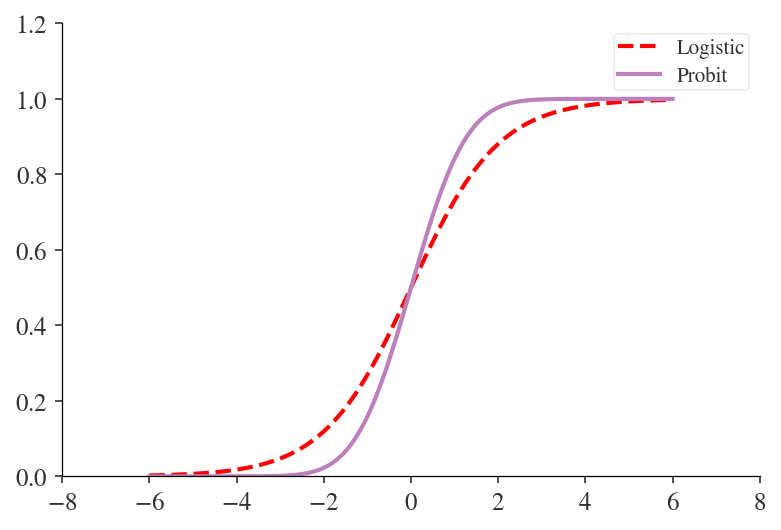

In [46]:
import scipy.stats as st

fig, ax = plt.subplots()
support = np.linspace(-6, 6, 1000)
ax.plot(support, st.logistic.cdf(support), "r-", ls="--", label="Logistic")
ax.plot(support, st.norm.cdf(support), label="Probit")
ax.legend()
ax.set_ylim(0, None)
ax.set_ylim(0, None)
plt.show()

What difference there is, is that logistic regression puts more weight into the tails of the distribution. Arguably, logit is easier to interpret too. With logistic regression, a one unit change in $x_i$ is associated with a $\beta_i$ change in the log odds of a 1 outcome or, alternatively, an $e^{\beta_i}$-fold change in the odds, all else being equal. With a probit, this is a change of $\beta_i z$ for $z$ a normalised variable that you'd have to convert into a predicted probability using the normal CDF.

### Generalised linear models

Logit and probit (and OLS for that matter) as special cases of a class of models such that $g$ is a 'link' function connects a function of regressors to the output, and $\mu$ is the mean of a conditional response distribution at a given point in the space of regressors. When $g(\mu) = X'\beta$, we just get regular OLS. When it's logit, we have

$$
{\displaystyle \mu= \mathbb{E}(Y\mid X=x) =g^{-1}(X'\beta)= \frac{1}{1 + e^{-X'\beta}}.}
$$

But as well as the ones we've seen, there are many possible link functions one can use via the catch-all `glm` function. These come in different 'families' of distributions, with the default for the binomial family being logit. So, running `smf.glm('GRADE ~ GPA + TUCE + PSI', data=df, family=sm.families.Binomial()).fit()` will produce exactly the same as we got both using the `logit` function. For more on the families of distributions and possible link functions, see the [relevant part](https://www.statsmodels.org/stable/glm.html#) of the **statsmodels** documentation.

## Linear probability model

When $y$ takes values in $\{0, 1\}$ but the model looks like

$$
y = x' \cdot \beta
$$

and is estimated by OLS then you have a linear probability model. In this case, the interpretion of a unit change in $x_i$ is that it induces a $\beta_i$ *change in probability* of $y$. Note that homoskedasticity does not hold for the linear probability model.

## Violations of the classical linear model (CLM)

### Heteroskedasticity

If an estimated model is homoskedastic then its random variables have equal (finite) variance. This is also known as homogeneity of variance. Another way of putting it is that, for all *observations* $i$ in an estimated model $y_i = X_i\hat{\beta} + \epsilon_i$ then

$$
\mathbb{E}(\epsilon_i \epsilon_i) = \sigma^2
$$

When this relationship does not hold, an estimated model is said to be heteroskedastic.

To test for heteroskedasticity, you can use **statsmodels**' versions of the [Breusch-Pagan](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan) or [White](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html#statsmodels.stats.diagnostic.het_white) tests with the null hypothesis that the estimated model is homoskedastic. If the null hypothesis is rejected, then standard errors, t-statistics, and F-statistics are invalidated. In this case, you will need HAC (heteroskedasticity and auto-correlation consistent) standard errors, t- and F-statistics.

To obtain HAC standard errors from existing regression results in a variable `results`, you can use (for 1 lag):

```python
results.get_robustcov_results('HAC', maxlags=1).summary()
```

## Quantile regression

Quantile regression estimates the conditional quantiles of a response variable. In some cases, it can be more robust to outliers and, in the case of the $q=0.5$ quantile it is equivalent LAD (Least Absolute Deviation) regression. Let's look at an example of quantile regression in action, lifted direct from the **statsmodels** [documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html) and based on a Journal of Economic Perspectives paper by Koenker and Hallock.

In [47]:
df = sm.datasets.engel.load_pandas().data
df.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


What we have here are two sets of related data. Let's perform several quantile regressions from 0.1 to 0.9 in steps of 0.1

In [48]:
mod = smf.quantreg("foodexp ~ income", df)
quantiles = np.arange(0.1, 1.0, 0.1)
q_results = [mod.fit(q=x) for x in quantiles]

The $q=0.5$ entry will be at the `4` index; let's take a look at it: 

In [49]:
print(q_results[4].summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Wed, 06 Oct 2021   No. Observations:                  235
Time:                        17:40:18   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


Let's take a look at the results for all of the regressions *and* let's add in OLS for comparison:

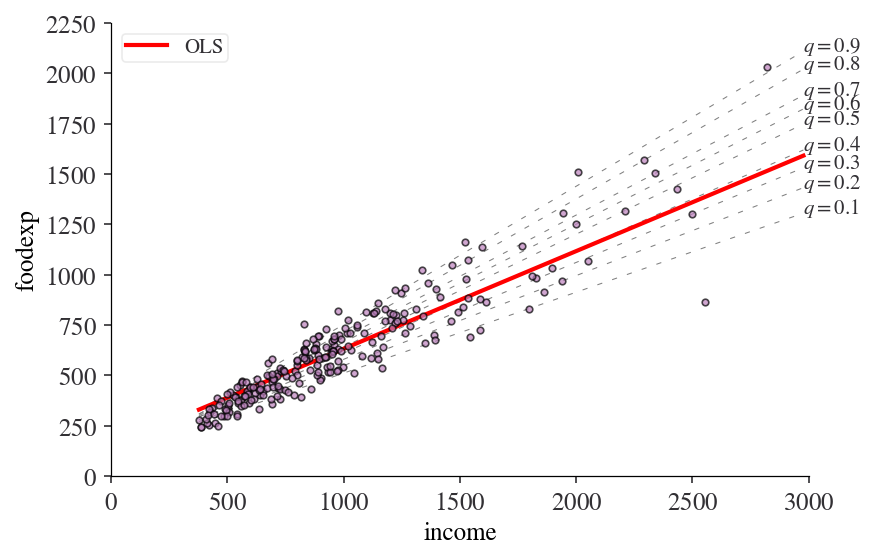

In [50]:
ols_res = smf.ols("foodexp ~ income", df).fit()

get_y = lambda a, b: a + b * x
x = np.arange(df.income.min(), df.income.max(), 50)
# Just to make the plot clearer
x_max = 3000
x = x[x < x_max]

fig, ax = plt.subplots()
df.plot.scatter(
    ax=ax, x="income", y="foodexp", alpha=0.7, s=10, zorder=2, edgecolor=None
)
for i, res in enumerate(q_results):
    y = get_y(res.params["Intercept"], res.params["income"])
    ax.plot(x, y, color="grey", lw=0.5, zorder=0, linestyle=(0, (5, 10)))
    ax.annotate(f"$q={quantiles[i]:1.1f}$", xy=(x.max(), y.max()))
y = get_y(ols_res.params["Intercept"], ols_res.params["income"])
ax.plot(x, y, color="red", label="OLS", zorder=0)
ax.legend()
ax.set_xlim(0, x_max)
plt.show()

This chart shows very clearly how quantile regression differs from OLS. The line fitted by OLS is trying to be all things to all points whereas the line fitted by quantile regression is focused only on its quantile. You can also see how points far from the median (not all shown) may be having a large influence on the OLS line.

## Rolling and recursive regressions

Rolling ordinary least squares applies OLS (ordinary least squares) across a fixed window of observations and then rolls (moves or slides) that window across the data set. They key parameter is `window`, which determines the number of observations used in each OLS regression. Recursive regression is equivalent to rolling regression but with a window that expands over time.

Let's first create some synthetic data to perform estimation on:

In [51]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=200, n_features=2, random_state=0, noise=4.0, bias=0)
df = pd.DataFrame(X).rename(columns={0: "feature0", 1: "feature1"})
df["target"] = y
df.head()

,feature0,feature1,target
0,-0.955945,-0.345982,-36.740556
1,-1.225436,0.844363,7.190031
2,-0.692050,1.536377,44.389018
3,0.010500,1.785870,57.019515
4,-0.895467,0.386902,-16.088554


Now let's fit the model using a formula and a `window` of 25 steps.

In [52]:
roll_reg = RollingOLS.from_formula(
    "target ~ feature0 + feature1 -1", window=25, data=df
)
model = roll_reg.fit()

Note that -1 in the formala suppresses the intercept. We can see the parameters using `model.params`. Here are the params for time steps between 20 and 30:

In [53]:
model.params[20:30]

,feature0,feature1
20,NaN,NaN
21,NaN,NaN
22,NaN,NaN
...,...,...
27,20.532655,34.919468
28,20.470171,35.365235
29,20.002261,35.666997


Note that there aren't parameters for entries between 0 and 23 because our window is 25 steps wide. We can easily look at how any of the coefficients are changing over time. Here's an example for 'feature0'.

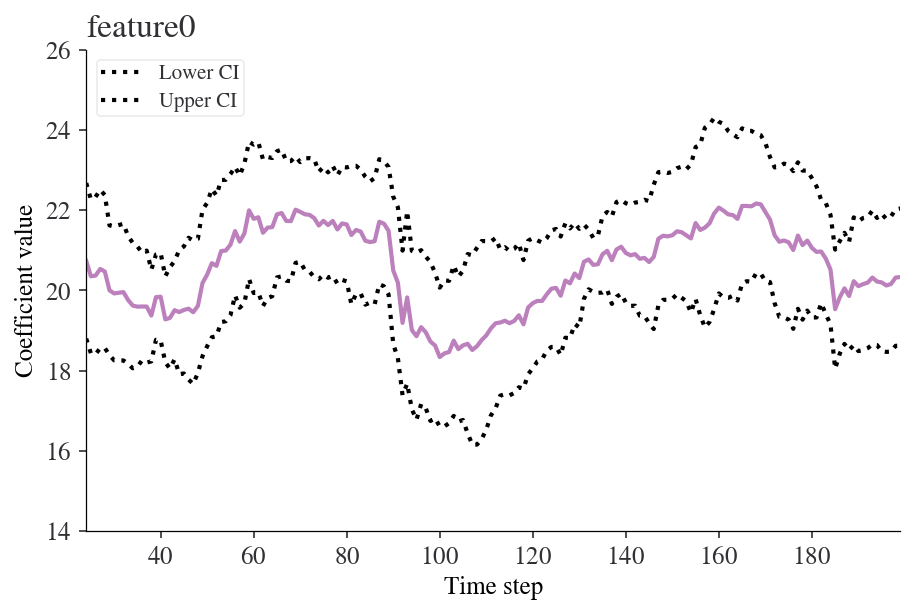

In [54]:
fig = model.plot_recursive_coefficient(variables=["feature0"])
plt.xlabel("Time step")
plt.ylabel("Coefficient value")
plt.show()

A rolling regression with an *expanding* rather than *moving* window is effectively a recursive least squares model. We can do this instead using the `RecursiveLS` function from **statsmodels**. Let's fit this to the whole dataset:

In [55]:
reg_rls = sm.RecursiveLS.from_formula("target ~ feature0 + feature1 -1", df)
model_rls = reg_rls.fit()
print(model_rls.summary())

                           Statespace Model Results                           
Dep. Variable:                 target   No. Observations:                  200
Model:                    RecursiveLS   Log Likelihood                -570.923
Date:                Wed, 06 Oct 2021   R-squared:                       0.988
Time:                        17:40:19   AIC                           1145.847
Sample:                             0   BIC                           1152.444
                                - 200   HQIC                          1148.516
Covariance Type:            nonrobust   Scale                           17.413
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feature0      20.6872      0.296     69.927      0.000      20.107      21.267
feature1      34.0655      0.302    112.870      0.000      33.474      34.657
Ljung-Box (L1) (Q):                   2.02   Jarque-

But now we can look back at how the values of the coefficients changed over time too:

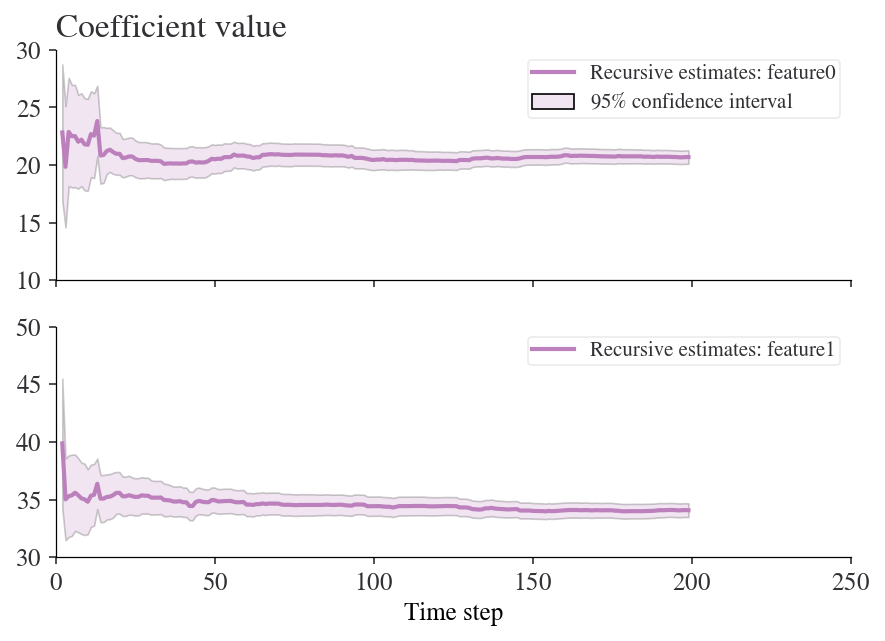

In [56]:
fig = model_rls.plot_recursive_coefficient(
    range(reg_rls.k_exog), legend_loc="upper right"
)
ax_list = fig.axes
for ax in ax_list:
    ax.set_xlim(0, None)
ax_list[-1].set_xlabel("Time step")
ax_list[0].set_title("Coefficient value");

## Regression plots

**statsmodels** has a number of built-in plotting methods to help you understand how well your regression is capturing the relationships you're looking for. Let's see a few examples of these using **statsmodels** built-in Statewide Crime data set:



In [57]:
crime_data = sm.datasets.statecrime.load_pandas()
print(sm.datasets.statecrime.NOTE)

::

    Number of observations: 51
    Number of variables: 8
    Variable name definitions:

    state
        All 50 states plus DC.
    violent
        Rate of violent crimes / 100,000 population. Includes murder, forcible
        rape, robbery, and aggravated assault. Numbers for Illinois and
        Minnesota do not include forcible rapes. Footnote included with the
        American Statistical Abstract table reads:
        "The data collection methodology for the offense of forcible
        rape used by the Illinois and the Minnesota state Uniform Crime
        Reporting (UCR) Programs (with the exception of Rockford, Illinois,
        and Minneapolis and St. Paul, Minnesota) does not comply with
        national UCR guidelines. Consequently, their state figures for
        forcible rape and violent crime (of which forcible rape is a part)
        are not published in this table."
    murder
        Rate of murders / 100,000 population.
    hs_grad
        Percent of population h

First, let's look at a Q-Q plot to get a sense of how the variables are distributed. This uses **scipy**'s stats module. The default distribution is normal but you can use any that **scipy** supports.

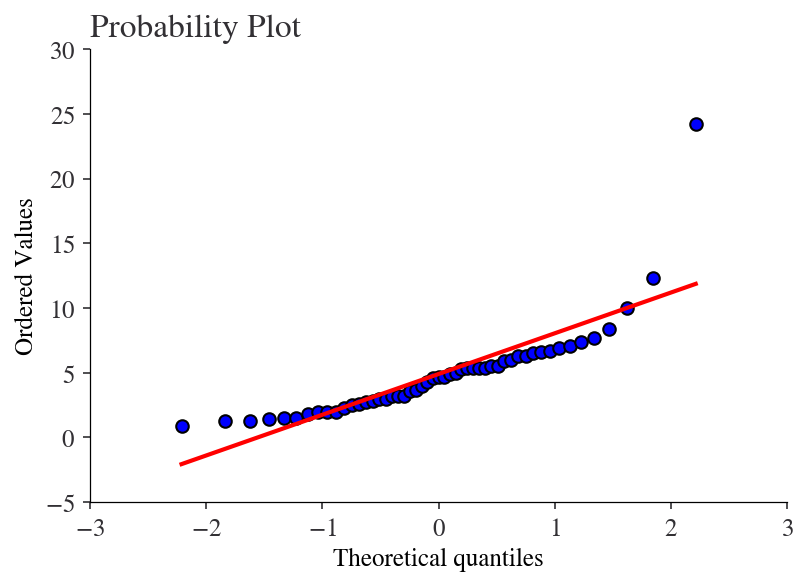

In [58]:
st.probplot(crime_data.data["murder"], dist="norm", plot=plt);

Clearly, this is not quite normal and there are some serious outliers in the tails.

Let's run take a look at the unconditional relationship we're interested in: how murder depends on high school graduation. We'll use [**plotnine**](https://plotnine.readthedocs.io/en/stable/index.html)'s `geom_smooth` to do this but bear in mind it will only run a linear model of `'murder ~ hs_grad'` and ignore the other covariates.

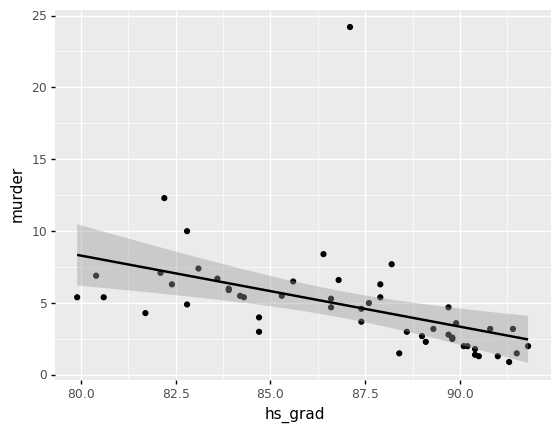

<ggplot: (8770400982001)>

In [59]:
from plotnine import *

(
    ggplot(crime_data.data, aes(y="murder", x="hs_grad"))
    + geom_point()
    + geom_smooth(method="lm")
)

We can take into account those other factors by using a partial regression plot that asks what does $\mathbb{E}(y|X)$ look like as a function of $\mathbb{E}(x_i|X)$? (Use `obs_labels=False` to remove data point labels.)

eval_env: 1


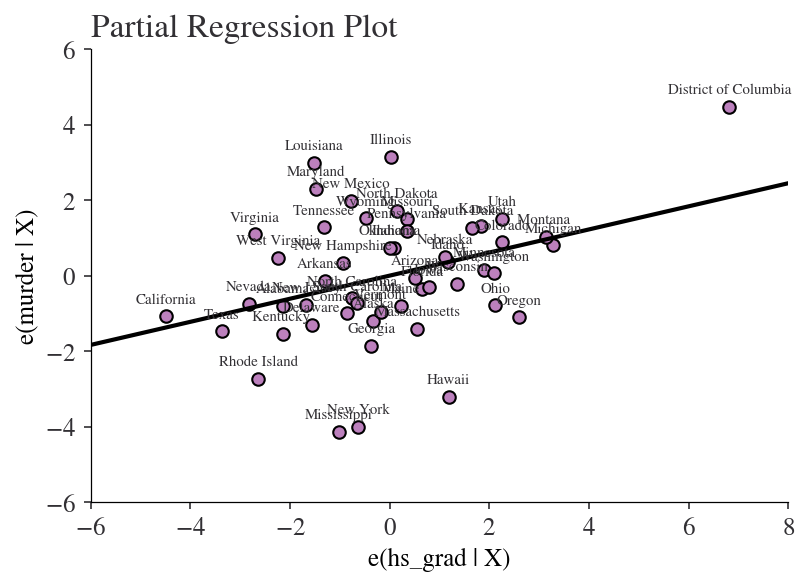

In [60]:
with plt.rc_context({"font.size": 5}):
    sm.graphics.plot_partregress(
        endog="murder",
        exog_i="hs_grad",
        exog_others=["urban", "poverty", "single"],
        data=crime_data.data,
        obs_labels=True,
    )
    plt.show()

At this point, the results of the regression are useful context.

In [61]:
results_crime = smf.ols(
    "murder ~ hs_grad + urban + poverty + single", data=crime_data.data
).fit()
print(results_crime.summary())

                            OLS Regression Results                            
Dep. Variable:                 murder   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     50.08
Date:                Wed, 06 Oct 2021   Prob (F-statistic):           3.42e-16
Time:                        17:40:21   Log-Likelihood:                -95.050
No. Observations:                  51   AIC:                             200.1
Df Residuals:                      46   BIC:                             209.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -44.1024     12.086     -3.649      0.0

Putting the multicollinearity problems to one side, we see that the relationship shown in the partial regression plot is also implied by the coefficient on `hs_grad` in the regression table.

We can also look at an in-depth summary of one exogenous regressor and its relationship to the outcome variable. Each of these types of regression diagnostic are available individually, or for all regressors at once, too. The first panel is the chart we did with **plotnine** rendered differently (and, one could argue, more informatively). Most of the plots below are self-explanatory except for the third one,  the CCPR (Component-Component plus Residual) plot. This provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables. 

eval_env: 1


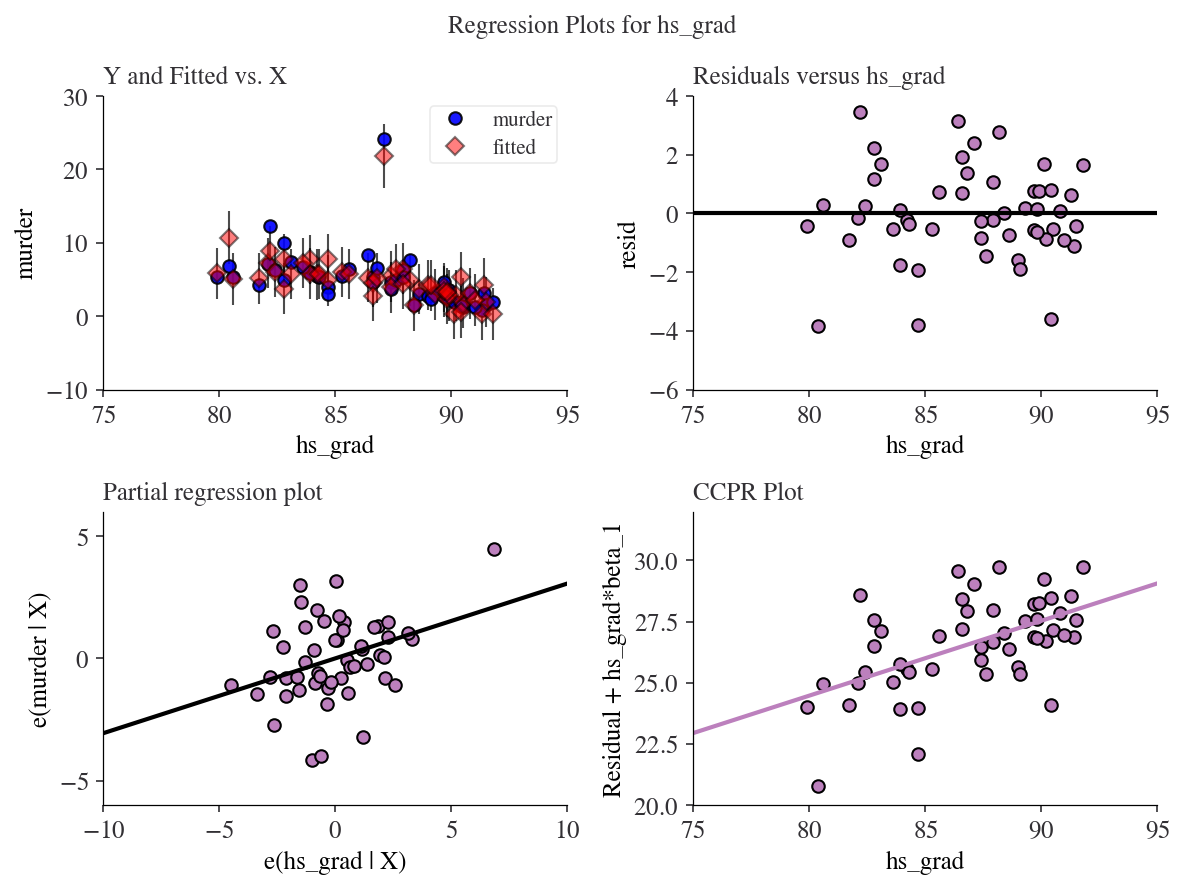

In [62]:
fig = plt.figure(figsize=(8, 6), dpi=150)

sm.graphics.plot_regress_exog(results_crime, "hs_grad", fig=fig)
plt.tight_layout()
plt.show()

**statsmodels** can also produce influence plots of the 'externally studentised' residuals vs. the leverage of each observation as measured by the so-called hat matrix $X(X^{\;\prime}X)^{-1}X^{\;\prime}$ (because it puts the 'hat' on $y$). Externally studentised residuals are residuals that are scaled by their standard deviation. High leverage points could exert an undue influence over the regression line, but only if the predicted $y$ values of a regression that was fit with them excluded was quite different. In the example below, DC is having a big influence.

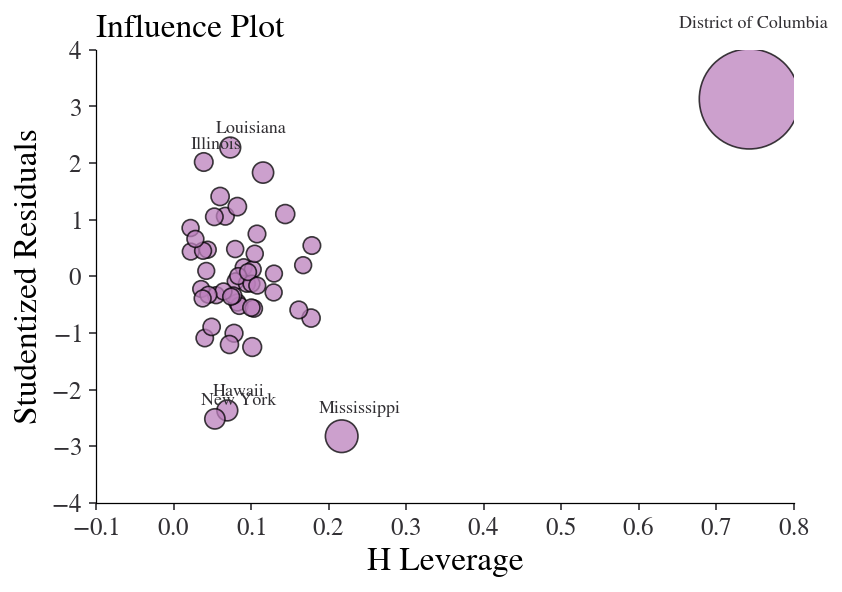

In [63]:
with plt.rc_context({"font.size": 6}):
    sm.graphics.influence_plot(results_crime)

Finally, it's nice to be able to see plots of our coefficients along with their standard errors. There isn't a built-in **statsmodels** option for this, but happily it's easy to extract the results of regressions in a sensible format. Using the `results` object from earlier, and excluding the intercept, we can get the coefficients from `results.params[1:]` and the associated errors from `results.bse[1:]`.

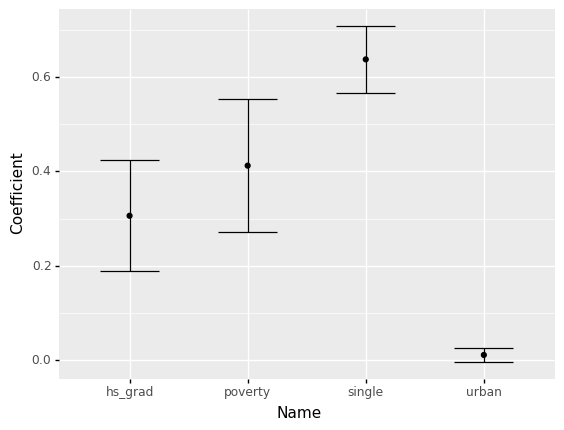

<ggplot: (8770402812739)>

In [64]:
# Put the results into a dataframe with Name, Coefficient, Error
res_df = (
    pd.concat([results_crime.params[1:], results_crime.bse[1:]], axis=1)
    .reset_index()
    .rename(columns={"index": "Name", 0: "Coefficient", 1: "Error"})
)
# Plot the coefficient values and their errors
(
    ggplot(res_df)
    + geom_point(aes("Name", "Coefficient"))
    + geom_errorbar(aes(x="Name", ymin="Coefficient-Error", ymax="Coefficient+Error"))
)

## Specification curve analysis

When specifying a model, modellers have many options. These can be informed by field intelligence, priors, and even misguided attempts to find a significant result. Even with the best of intentions, research teams can reach entirely different conclusions using the same, or similar, data because of different choices made in preparing data or in modelling it.

There’s formal evidence that researchers really do make different decisions; one study {cite}`silberzahn2018many` gave the same research question - whether soccer referees are more likely to give red cards to dark-skin-toned players than to light-skin-toned players - to 29 different teams. From the abstract of that paper:

> Analytic approaches varied widely across the teams, and the estimated effect sizes ranged from 0.89 to 2.93 (Mdn = 1.31) in odds-ratio units. Twenty teams (69%) found a statistically significant positive effect, and 9 teams (31%) did not observe a significant relationship. Overall, the 29 different analyses used 21 unique combinations of covariates. Neither analysts’ prior beliefs about the effect of interest nor their level of expertise readily explained the variation in the outcomes of the analyses. Peer ratings of the quality of the analyses also did not account for the variability.

So not only were different decisions made, there seems to be no clearly identifiable reason for them. There is usually scope for reasonable alternative model specifications when estimating coefficients, and those coefficients will vary with those specifications. 

Specification curve analysis {cite}`simonsohn2020specification` looks for a more exhaustive way of trying out alternative specifications. The three steps of specification curve analysis are:

1. identifying the set of theoretically justified, statistically valid, and non-redundant analytic specifications;

2. displaying alternative results graphically, allowing the identification of decisions producing different results; and

3. conducting statistical tests to determine whether as a whole results are inconsistent with the null hypothesis.

For a good example of specification curve analysis in action, see this recent Nature Human Behaviour paper {cite}`orben2019association` on the association between adolescent well-being and the use of digital technology.

We'll use the [**specification curve analysis**](https://specification-curve.readthedocs.io/en/latest/readme.html) package to do the first two, which you can install with `pip install specification_curve` (full disclosure: I wrote this package). To demonstrate the full functionality, we'll create a second, alternative 'hp' that is a transformed version of the original.

In [65]:
mpg["hp_boxcox"], _ = st.boxcox(mpg["hp"])

Now let's create a specification curve. We need to specify the data, the different outcome variables we'd like to try, `y_endog`; the different possible versions of the main regressor of interest, `x_exog`; the possible controls, `controls`; any controls that should always be included, `always_include`; and any categorical variables to include class-by-class, `cat_expand`. Some of these accept lists of variables as well as single reggressors. The point estimates that have confidence intervals which include zero are coloured in grey, instead of blue. There is also an `exclu_grps` option to exclude certain combinations of regressors, and you can pass alternative estimators to fit, for example `fit(estimator=sm.Logit)`.

Fit complete


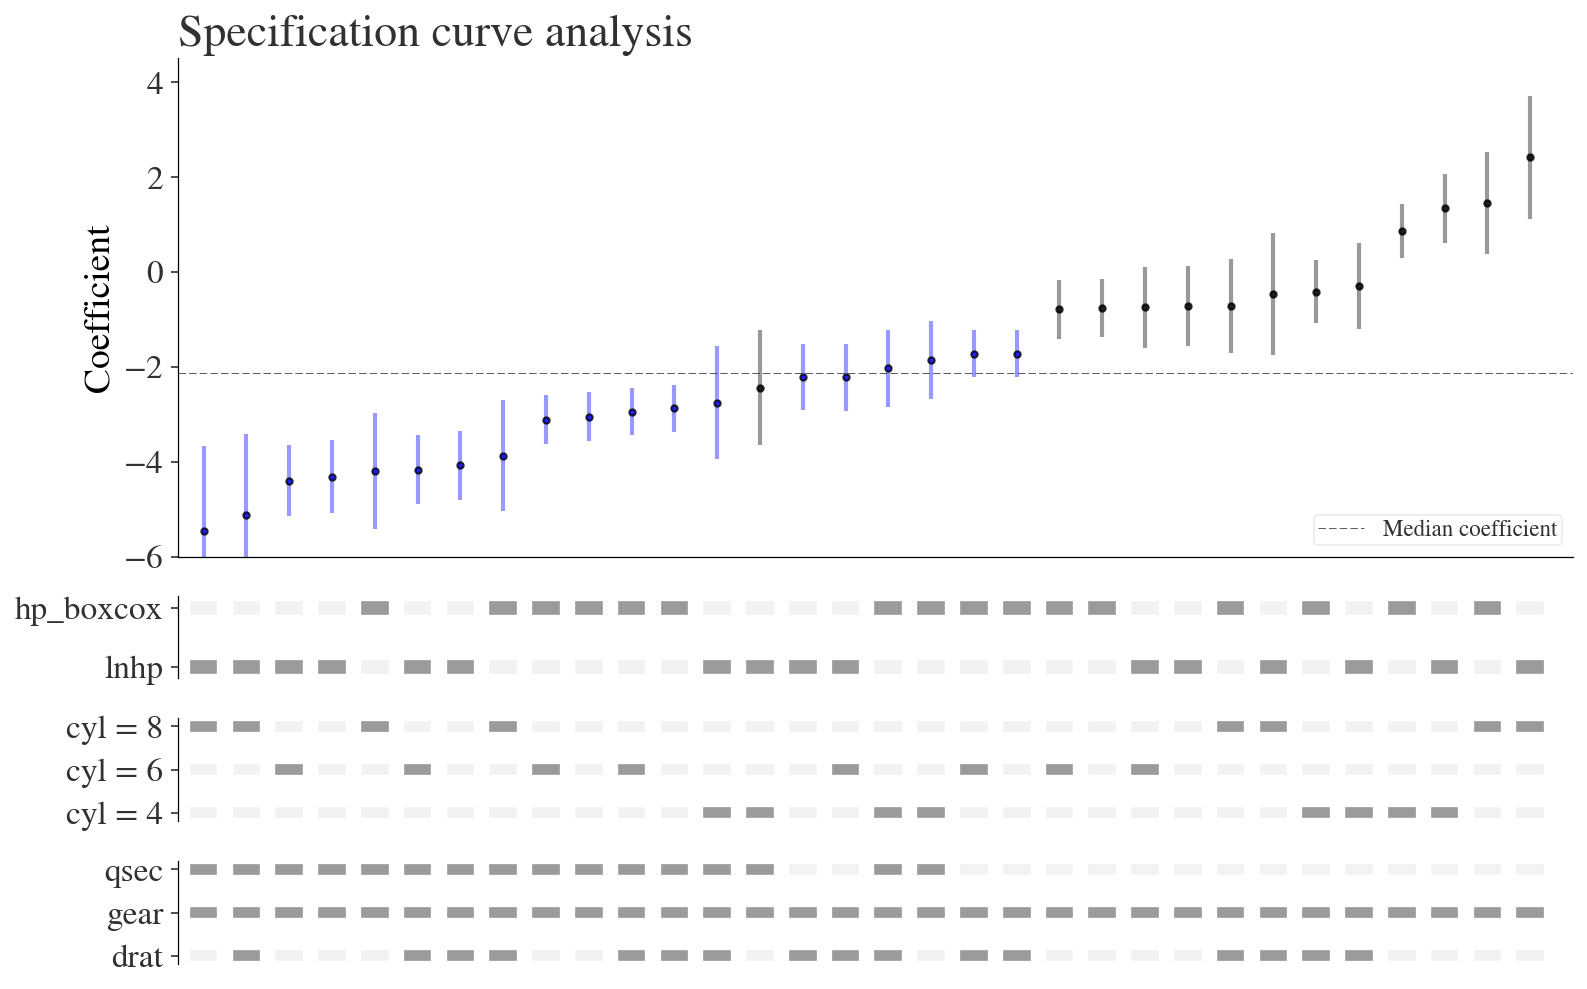

In [66]:
from specification_curve import specification_curve as specy

sc = specy.SpecificationCurve(
    mpg,
    y_endog="mpg",
    x_exog=["lnhp", "hp_boxcox"],
    controls=["drat", "qsec", "cyl", "gear"],
    always_include=["gear"],
    cat_expand="cyl",
)
sc.fit()
sc.plot()

## Review

In this very short introduction to regression with code, you should have learned how to:

- ✅ perform linear OLS regressions with code;
- ✅ add fixed effects/categorical variables to regressions;
- ✅ use different standard errors; 
- ✅ use models with transformed regressors;
- ✅ use the formula or array APIs for **statsmodels** and **linearmodels**;
- ✅ show the results from multiple models;
- ✅ perform IV regressions;
- ✅ perform GLM regressions; and
- ✅ use plots as a way to interrogate regression results.